In [3]:
## 모듈 로드
import pf
import osmnx as ox

In [4]:
# =========================
# Reproducibility Parameters
# =========================
PLACE_NAME = "Ilsandong-gu, Goyang-si, South Korea"
SEED = 0
N_OD = 2000
WEIGHT = "length"
OUT_DIR = "outputs"

# (선택) 분석 필터 기본값: 다음 단계에서 쓸 예정
MIN_PATH1 = 3      # edge 노출이 너무 적은 건 순위 비교에서 제외할 때 사용
TOP_K = 200        # top-k 비교/시각화 때 사용할 값


### 1. Network generation

In [5]:
Gu = pf.build_drive_graph(PLACE_NAME)

print("Graph built.")
print("Nodes:", len(Gu.nodes))
print("Edges:", Gu.number_of_edges())


Graph built.
Nodes: 2343
Edges: 6341


### 2. OD sampling

In [6]:
od_pairs = pf.sample_od_pairs(Gu, N_OD, seed=SEED)

print("OD pairs sampled:", len(od_pairs))
print("Example:", od_pairs[:3])


OD pairs sampled: 2000
Example: [(np.int64(9369825760), np.int64(5833798060)), (np.int64(3966737269), np.int64(3955635841)), (np.int64(3955635824), np.int64(9366887327))]


### 3. Forcedness results table

In [7]:
df_edge, df_od = pf.compute_tables(Gu, od_pairs, weight=WEIGHT)

print("Computed tables.")
print("df_edge rows:", len(df_edge))
print("df_od rows:", len(df_od))


Computed tables.
df_edge rows: 4872
df_od rows: 2000


### 4. Save, sanity check

In [8]:
pf.save_tables(df_edge, df_od, out_dir=OUT_DIR)

print("Saved to:", OUT_DIR)
print("\nOD status summary:")
print(pf.summarize_od_status(df_od))

print("\n[edge table head]")
print(df_edge.head())


Saved to: outputs

OD status summary:
{'total': 2000, 'reachable': 1981, 'status_counts': {'ok': 1981, 'no_path': 19}}

[edge table head]
            u           v  forcedness_ln_mean  forcedness_ln_median  \
0  9369825760  9369825759            0.002245              0.002245   
1  9369825759  9352983537            0.003426              0.001838   
2  9352983537  9352983540            0.004037              0.002123   
3  9352983540  4712721504            0.002460              0.001564   
4  4712721504  2093023432            0.002501              0.001838   

   n_forcedness  n_path1  n_no_alt  no_alt_ratio  
0             1        1         0           0.0  
1            25       25         0           0.0  
2            26       26         0           0.0  
3            22       22         0           0.0  
4            23       23         0           0.0  


### Next Step A. 논문용 결과 표 만들기 (Top-k + 필터)

df_edge에서 n_path1 >= MIN_PATH1 같은 필터 적용

forcedness_ln_median 기준 top-k 추출

논문 표로 저장 (outputs/topk_forcedness.csv 등)

In [20]:
# TODO (나중에 구현):
# 1) df_edge 필터링 (예: n_path1 >= MIN_PATH1)
# 2) forcedness_ln_median 기준 정렬 후 TOP_K 추출
# 3) outputs/topk_forcedness.csv 저장
pass


Edges in df_edge: 4,872
n_path1 == 1 비율: 0.201
n_path1 == 2 비율: 0.128
n_path1 <= 2 비율: 0.329

[n_path1 구간별 비율]


,ratio,count,cum_ratio
n_path1,,,
1,0.200944,979,0.200944
2,0.128284,625,0.329228
3,0.087438,426,0.416667
4-5,0.119869,584,0.536535
6-10,0.150041,731,0.686576
11-20,0.110427,538,0.797003
21-50,0.125821,613,0.922824
51-100,0.065066,317,0.987890
101-200,0.012110,59,1.000000


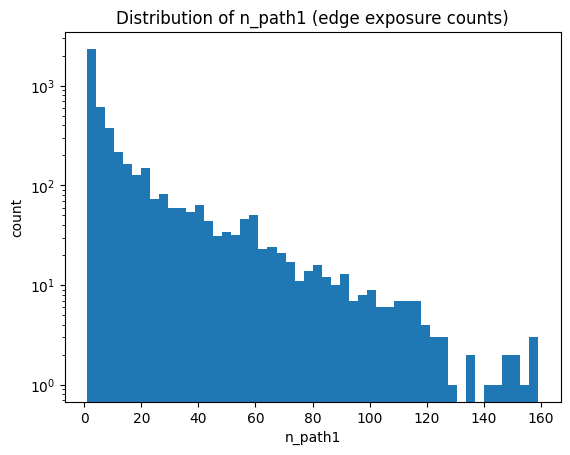

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n = df_edge["n_path1"].astype(int)

ratio_le2 = (n <= 2).mean()
ratio_eq1 = (n == 1).mean()
ratio_eq2 = (n == 2).mean()

print(f"Edges in df_edge: {len(df_edge):,}")
print(f"n_path1 == 1 비율: {ratio_eq1:.3f}")
print(f"n_path1 == 2 비율: {ratio_eq2:.3f}")
print(f"n_path1 <= 2 비율: {ratio_le2:.3f}")

# ✅ bin edge는 labels보다 1개 더 많아야 함
bins = [0, 1, 2, 3, 5, 10, 20, 50, 100, 200, 500, 1000, 10**9]
labels = ["1", "2", "3", "4-5", "6-10", "11-20", "21-50", "51-100", "101-200", "201-500", "501-1000", ">1000"]

cat = pd.cut(n, bins=bins, labels=labels, include_lowest=True, right=True)
summary = cat.value_counts(normalize=True).sort_index().rename("ratio").to_frame()
summary["count"] = cat.value_counts().sort_index()
summary["cum_ratio"] = summary["ratio"].cumsum()

print("\n[n_path1 구간별 비율]")
display(summary)

plt.figure()
plt.hist(n.values, bins=50)
plt.title("Distribution of n_path1 (edge exposure counts)")
plt.xlabel("n_path1")
plt.ylabel("count")
plt.yscale("log")
plt.show()


In [10]:
import numpy as np
import pandas as pd

# --- 1) low-exposure 그룹 정의 (n_path1 <= 2) ---
low = df_edge[df_edge["n_path1"] <= 2].copy()
high = df_edge[df_edge["n_path1"] > 2].copy()

print("Total edges in df_edge:", len(df_edge))
print("Low-exposure (n_path1<=2):", len(low), f"({len(low)/len(df_edge):.3f})")
print("High-exposure (n_path1>2):", len(high), f"({len(high)/len(df_edge):.3f})")

# --- 2) forcedness 값이 실제로 있는 비율 (ok 케이스 누적이 있어야 값이 생김) ---
low_valid = low[np.isfinite(low["forcedness_ln_median"])]
high_valid = high[np.isfinite(high["forcedness_ln_median"])]

print("\n[Valid forcedness ratio]")
print("  low  valid:", len(low_valid), f"({len(low_valid)/len(low):.3f})")
print("  high valid:", len(high_valid), f"({len(high_valid)/len(high):.3f})")

# --- 3) forcedness 분포 비교 (median 기준) ---
def desc(series: pd.Series):
    return series.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

print("\n[forcedness_ln_median distribution | low (n_path1<=2)]")
display(desc(low_valid["forcedness_ln_median"]))

print("\n[forcedness_ln_median distribution | high (n_path1>2)]")
display(desc(high_valid["forcedness_ln_median"]))

# --- 4) 상위 forcedness TOP_K 중 low-exposure가 얼마나 섞였는지 ---
TOP_K_CHECK = TOP_K if "TOP_K" in globals() else 200

rank_base = df_edge.copy()
rank_base = rank_base[np.isfinite(rank_base["forcedness_ln_median"])].copy()
rank_base = rank_base.sort_values("forcedness_ln_median", ascending=False)

topk = rank_base.head(TOP_K_CHECK).copy()
topk["is_low_exposure"] = topk["n_path1"] <= 2

print(f"\n[Top-{TOP_K_CHECK} by forcedness_ln_median]")
print("  low-exposure count:", int(topk["is_low_exposure"].sum()))
print("  low-exposure ratio:", float(topk["is_low_exposure"].mean()))

# --- 5) low-exposure edge 중 forcedness가 큰 애들만 따로 보기 (디버깅/검토용) ---
print(f"\n[Low-exposure edges within Top-{TOP_K_CHECK}] (head 20)")
display(topk[topk["is_low_exposure"]][
    ["u", "v", "forcedness_ln_median", "forcedness_ln_mean", "n_path1", "n_forcedness"]
].head(20))


Total edges in df_edge: 4872
Low-exposure (n_path1<=2): 1604 (0.329)
High-exposure (n_path1>2): 3268 (0.671)

[Valid forcedness ratio]
  low  valid: 1604 (1.000)
  high valid: 3268 (1.000)

[forcedness_ln_median distribution | low (n_path1<=2)]


count    1.604000e+03
mean     9.179661e-03
std      5.730083e-02
min      4.862155e-11
50%      1.342593e-03
75%      4.322269e-03
90%      1.290142e-02
95%      2.537827e-02
99%      1.285457e-01
max      1.464557e+00
Name: forcedness_ln_median, dtype: float64


[forcedness_ln_median distribution | high (n_path1>2)]


count    3.268000e+03
mean     1.660120e-03
std      2.661626e-03
min      4.862155e-11
50%      7.744102e-04
75%      1.827704e-03
90%      3.972202e-03
95%      5.758087e-03
99%      1.264131e-02
max      4.638815e-02
Name: forcedness_ln_median, dtype: float64


[Top-200 by forcedness_ln_median]
  low-exposure count: 166
  low-exposure ratio: 0.83

[Low-exposure edges within Top-200] (head 20)


,u,v,forcedness_ln_median,forcedness_ln_mean,n_path1,n_forcedness
3761,6518898217,4698286784,1.464557,1.464557,1,1
1963,11383544065,11383544058,1.208460,1.208460,2,2
1596,9352983246,9352983245,0.839967,0.839967,1,1
3648,13169560595,13169560594,0.547324,0.547324,1,1
2282,5172386544,5172386368,0.286595,0.286595,1,1
2811,3966737321,5344150557,0.257017,0.257017,1,1
4584,7461492181,6041001002,0.256504,0.256504,1,1
4583,4553784751,7461492181,0.256504,0.256504,1,1
4688,11361103095,11361103093,0.189002,0.189002,1,1
4767,4634227107,2093021865,0.174948,0.174948,1,1


### Next Step B. 시각화

forcedness 분포(히스토그램/ECDF)

지도 위 top-k edge 강조(가능하면)

In [1]:
# TODO (나중에 구현):
# - 분포 plot
# - 지도 시각화
pass


- forcedness 먼저 강조

Used edges: 3268 / 4872
count    3.268000e+03
mean     1.660120e-03
std      2.661626e-03
min      4.862155e-11
25%      4.164536e-04
50%      7.744102e-04
75%      1.827704e-03
max      4.638815e-02
Name: forcedness_ln_median, dtype: float64


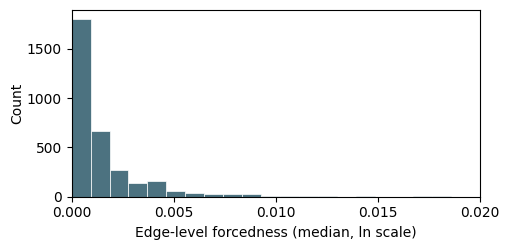

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 분석에 쓸 edge subset: 노출 너무 적은 edge 제거 + forcedness 존재하는 것만
edge_sub = df_edge.copy()
edge_sub = edge_sub[(edge_sub["n_path1"] >= MIN_PATH1) & np.isfinite(edge_sub["forcedness_ln_median"])]

plt.figure(figsize=(5.2,2.6))
plt.hist(
    edge_sub["forcedness_ln_median"].values,
    bins=50,
    color="#4C7280",
    edgecolor= "white",
    linewidth=0.5)

plt.xlabel("Edge-level forcedness (median, ln scale)")
plt.ylabel("Count", labelpad=2)
plt.xlim(0, 0.02)

plt.xticks(
    [0, 0.005, 0.01, 0.015, 0.02]
)
plt.tight_layout()

print("Used edges:", len(edge_sub), "/", len(df_edge))
print(edge_sub["forcedness_ln_median"].describe())


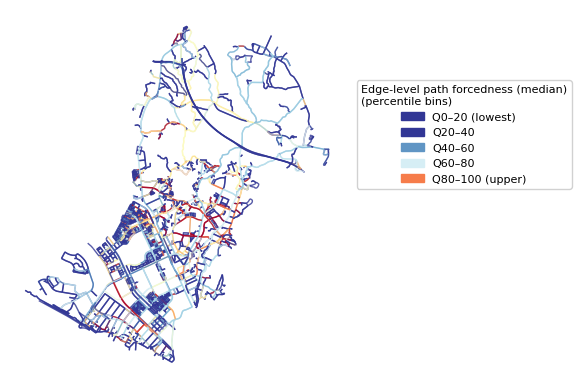

In [12]:
import matplotlib as mpl
# 0) 시각화용 그래프 로드 (원본)
place_name = PLACE_NAME
G_vis = ox.graph_from_place(place_name, network_type="drive")
G_vis = ox.distance.add_edge_lengths(G_vis)

# 1) edge gdf
gdf_edges = ox.graph_to_gdfs(
    G_vis, nodes=False, fill_edge_geometry=True
).reset_index()

# 2) (u,v) 평탄화: 동일 (u,v) 중 length 최소
gdf_edges_uv = (
    gdf_edges.sort_values("length")
             .drop_duplicates(subset=["u", "v"], keep="first")
)

# 3) edge-level forcedness 전체 (used edges만)
edge_all = df_edge.copy()
edge_all = edge_all[
    (edge_all["n_path1"] >= MIN_PATH1) &
    np.isfinite(edge_all["forcedness_ln_median"])
]

# 4) merge
gdf_all = gdf_edges_uv.merge(
    edge_all[["u", "v", "forcedness_ln_median"]],
    on=["u", "v"],
    how="left"
)

# forcedness 없는 edge는 0으로 (시각적 배경화)
gdf_all["forcedness_ln_median"] = gdf_all["forcedness_ln_median"].fillna(0.0)

# 5) 컬러 스케일 강제 압축 (상위 99퍼센타일)
vmax = np.percentile(
     gdf_all["forcedness_ln_median"], 95
 )

norm = mpl.colors.PowerNorm(gamma = 0.6, vmin=0, vmax=vmax)
cmap = plt.cm.RdYlBu_r

# 6) plot
fig, ax = plt.subplots()
gdf_edges_uv.plot(
    ax=ax,
    color="#B0B0B0",      # 연하지만 확실히 보이는 회색
    linewidth=0.3,       # ★ 중요: 이게 제일 큼
    alpha=0.2,
    zorder=1
)
gdf_all.plot(
    ax=ax,
    column="forcedness_ln_median",
    cmap=cmap,
    norm=norm,
    linewidth=1.0,
    alpha=0.8,
    zorder=2
)
import matplotlib.cm as cm

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # matplotlib 요구사항

# --- 5단계 범례 기준 (분위수) ---
import matplotlib.patches as mpatches

vals = gdf_all["forcedness_ln_median"].to_numpy()

# 분위수 경계: 0, 20, 40, 60, 80, 100%
qs = np.percentile(vals, [20, 40, 60, 80])

# 범례 라벨
labels = [
    "Q0–20 (lowest)",
    "Q20–40",
    "Q40–60",
    "Q60–80",
    "Q80–100 (upper)"
]

# 각 구간 대표값(중간값)으로 색상 샘플링
bounds = np.array([0.0, qs[0], qs[1], qs[2], qs[3], vmax])
midpoints = (bounds[:-1] + bounds[1:]) / 2

handles = [
    mpatches.Patch(color=cmap(norm(m)), label=lab)
    for m, lab in zip(midpoints, labels)
]

ax.legend(
    handles=handles,
    title="Edge-level path forcedness (median)\n(percentile bins)",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,          # 논문에선 frame 있는 게 더 읽기 쉬움
    framealpha=0.9,
    fontsize=8,
    title_fontsize=8
)

ax.set_axis_off()
plt.show()

Top-k edges requested: 200
Top-k edges matched with geometry: 200


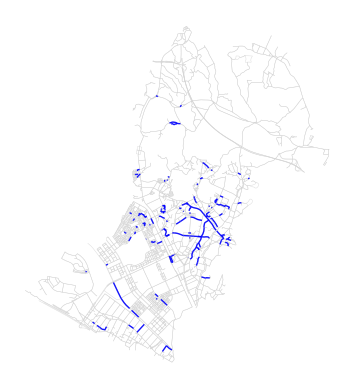

In [13]:
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

# 0) (중요) 원래 MultiDiGraph를 다시 로드해서 시각화에 사용
# build_drive_graph에서 원본 G도 같이 반환하도록 바꾸는 게 제일 깔끔하지만,
# 지금 당장이라면 place_name으로 다시 받아도 됨.
place_name = PLACE_NAME
G_vis = ox.graph_from_place(place_name, network_type="drive")
G_vis = ox.distance.add_edge_lengths(G_vis)

# 1) edge gdf (MultiDiGraph OK)
gdf_edges = ox.graph_to_gdfs(G_vis, nodes=False, fill_edge_geometry=True).reset_index()

# 2) (u,v)로 평탄화: 같은 (u,v)에 여러 key가 있으면 length 최소인 것만 남김
gdf_edges_uv = (
    gdf_edges.sort_values("length")
            .drop_duplicates(subset=["u", "v"], keep="first")
)

# 3) df_edge에서 top-k 선택
edge_rank = df_edge.copy()
edge_rank = edge_rank[(edge_rank["n_path1"] >= MIN_PATH1) & np.isfinite(edge_rank["forcedness_ln_median"])]
edge_rank = edge_rank.sort_values("forcedness_ln_median", ascending=False).head(TOP_K)

# 4) merge
gdf_top = gdf_edges_uv.merge(edge_rank, on=["u", "v"], how="inner")

print("Top-k edges requested:", TOP_K)
print("Top-k edges matched with geometry:", len(gdf_top))

# 5) plot
fig, ax = plt.subplots()
gdf_edges_uv.plot(ax=ax, linewidth=0.3, color="lightgray",alpha=0.9)
gdf_top.plot(ax=ax, linewidth=1.0,color="blue", alpha=0.9)

#ax.set_title(f"Top-{TOP_K} edges by forcedness (median), min n_path1={MIN_PATH1}")
ax.set_axis_off()
plt.show()


In [14]:
print("total edges (uv):", len(gdf_edges_uv))
print("top edges matched:", len(gdf_top))
print("ratio:", len(gdf_top) / len(gdf_edges_uv))

total edges (uv): 6341
top edges matched: 200
ratio: 0.03154076644062451


In [19]:
## save
fig.savefig(f"{OUT_DIR}/top{TOP_K}_forcedness_map.png", dpi=300, bbox_inches="tight")

In [15]:
topk_edges = (
    df_edge
    .loc[df_edge["n_path1"] >= MIN_PATH1]
    .sort_values("forcedness_ln_median", ascending=False)
    .head(TOP_K)
)

topk_edges["n_path1"].describe()

count    200.000000
mean       6.415000
std        5.590981
min        3.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       34.000000
Name: n_path1, dtype: float64

In [16]:
used_edges = df_edge.loc[df_edge["n_path1"] >= MIN_PATH1]

print("Used edges n_path1:")
print(used_edges["n_path1"].describe())

print("\nTop-k edges n_path1:")
print(topk_edges["n_path1"].describe())

Used edges n_path1:
count    3268.000000
mean       20.187576
std        24.341339
min         3.000000
25%         5.000000
50%         9.000000
75%        26.000000
max       159.000000
Name: n_path1, dtype: float64

Top-k edges n_path1:
count    200.000000
mean       6.415000
std        5.590981
min        3.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       34.000000
Name: n_path1, dtype: float64


In [17]:
quantiles = np.percentile(
    used_edges["n_path1"],
    [50, 75, 90, 95]
)

quantiles

topk_edges[["n_path1"]].assign(
    n_path1_quantile=lambda x: x["n_path1"].rank(pct=True)
).sort_values("n_path1", ascending=False)

,n_path1,n_path1_quantile
539,34,1.0000
540,31,0.9925
542,31,0.9925
541,29,0.9850
1496,25,0.9800
...,...,...
3186,3,0.1650
4146,3,0.1650
3184,3,0.1650
3971,3,0.1650


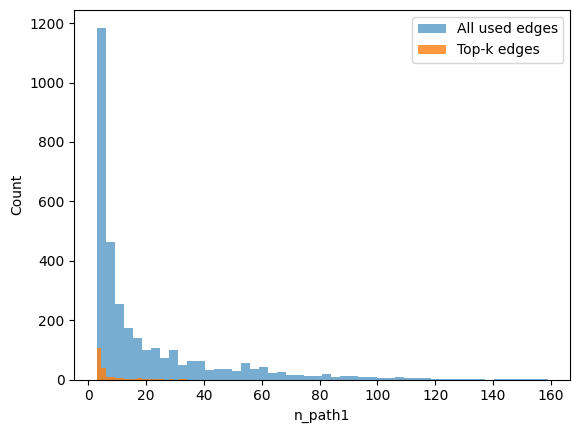

In [18]:
plt.hist(
    used_edges["n_path1"],
    bins=50,
    alpha=0.6,
    label="All used edges"
)

plt.hist(
    topk_edges["n_path1"],
    bins=20,
    alpha=0.8,
    label="Top-k edges"
)

plt.legend()
plt.xlabel("n_path1")
plt.ylabel("Count")
plt.show()

### Next Step C. Betweenness 비교 (Spearman + top-k overlap)

edge betweenness 계산

forcedness 순위 vs betweenness 순위

Spearman rho + top-k 교집합/자카드

In [19]:
import importlib, pf
importlib.reload(pf)

# Step C: forcedness vs betweenness
df_btw = pf.compute_edge_betweenness(Gu, weight=WEIGHT)

cmp_res = pf.compare_forcedness_betweenness(
    df_edge,
    df_btw,
    forced_col="forcedness_ln_median",
    min_path1=MIN_PATH1,
    top_k=TOP_K
)

cmp_res


{'n_compared_edges': 3268,
 'spearman_rho': -0.16236963228318663,
 'spearman_p': 9.58028209038769e-21,
 'topk_intersection': 0,
 'topk_jaccard': 0.0}

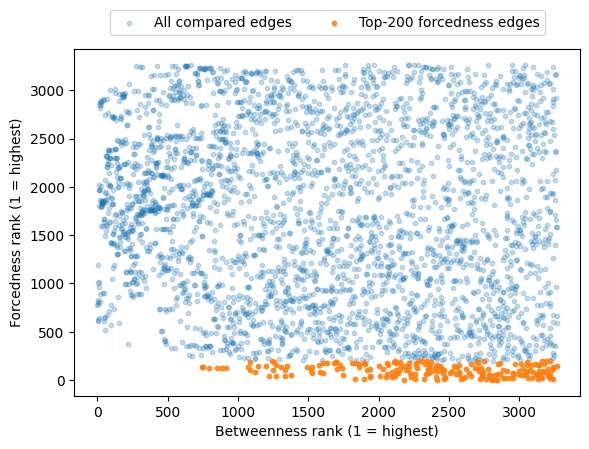

In [27]:
import importlib, pf
importlib.reload(pf)

df_cmp = pf.plot_rank_rank_forcedness_betweenness(
    df_edge, df_btw,
    forced_col="forcedness_ln_median",
    min_path1=3,
    top_k=200,
    #title="Rank–Rank: forcedness vs betweenness"
)

In [ ]:
plot_rank_rank_topk_only

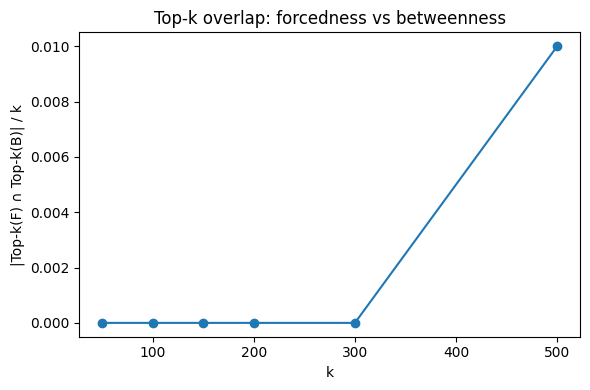

,k,intersection,overlap_ratio,jaccard
0,50,0,0.00,0.000000
1,100,0,0.00,0.000000
2,150,0,0.00,0.000000
3,200,0,0.00,0.000000
4,300,0,0.00,0.000000
5,500,5,0.01,0.005025


In [18]:
overlap_tbl = pf.plot_topk_overlap_curve(
    df_edge, df_btw,
    forced_col="forcedness_ln_median",
    min_path1=3,
    k_list=[50, 100, 150, 200, 300, 500],
    title="Top-k overlap: forcedness vs betweenness"
)
overlap_tbl

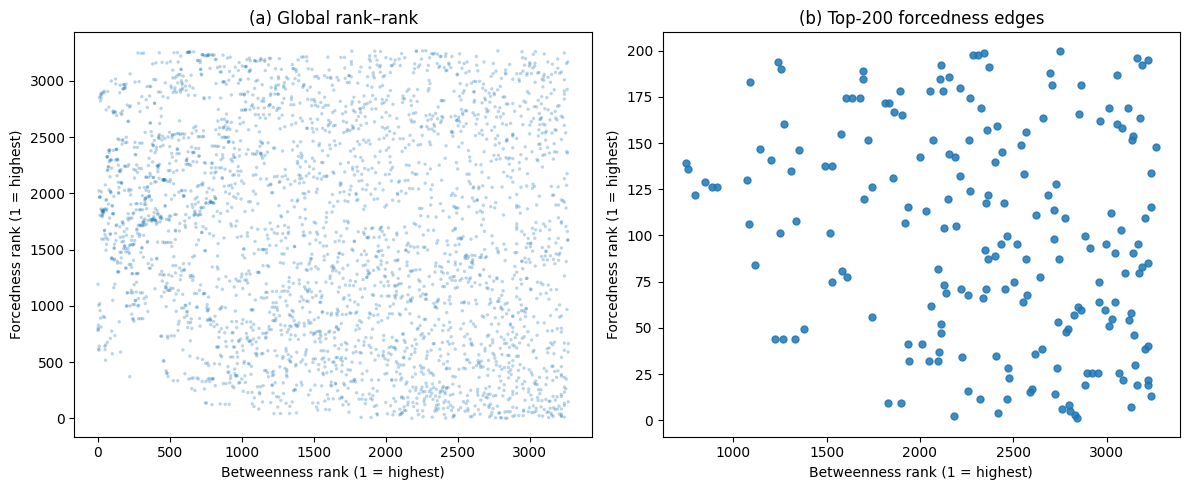

(               u           v  forcedness_ln_mean  forcedness_ln_median  \
 0     9369825759  9352983537            0.003426          1.838182e-03   
 1     9352983537  9352983540            0.004037          2.123044e-03   
 2     9352983540  4712721504            0.002460          1.564497e-03   
 3     4712721504  2093023432            0.002501          1.838182e-03   
 4     2093023432  2925528373            0.002677          1.947620e-03   
 ...          ...         ...                 ...                   ...   
 3263  5833798065  5833798064            0.006747          5.964422e-03   
 3264  3966723093  2352785202            0.000280          6.450507e-11   
 3265  7461497764  6147416348            0.006724          2.273094e-03   
 3266  9274304203  9274304199            0.049290          1.156710e-03   
 3267  2093021686  9202074167            0.004036          8.505054e-04   
 
       n_forcedness  n_path1  n_no_alt  no_alt_ratio  betweenness  rank_forced  \
 0              

In [23]:
import importlib, pf
importlib.reload(pf)

pf.plot_rank_rank_global_and_topk(
    df_edge, df_btw,
    forced_col="forcedness_ln_median",
    min_path1=MIN_PATH1,
    top_k=TOP_K,
    savepath="rank_rank_global_vs_topk.png"
)

### appendix : robustness of path forcedness

Building OD pool (n=20000): 100%|██████████| 20000/20000 [2:15:20<00:00,  2.46it/s]  


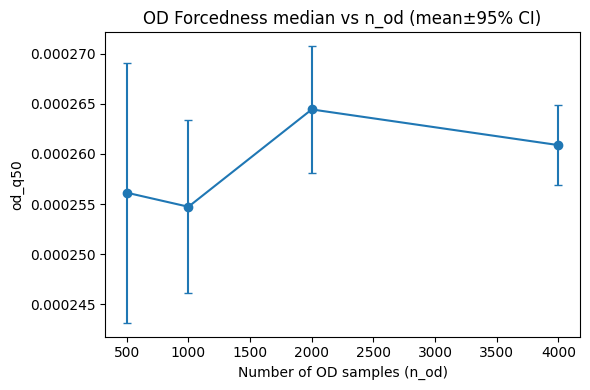

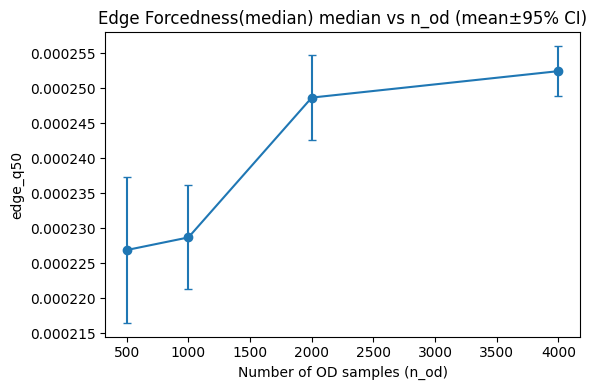

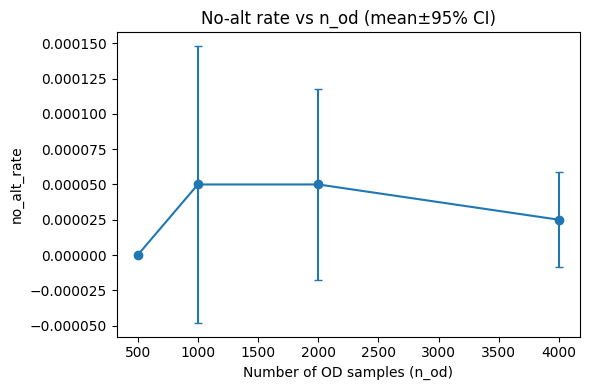

        od_q50              od_q90            edge_q50           no_alt_rate  \
          mean       std      mean       std      mean       std        mean   
n_od                                                                           
500   0.000256  0.000030  0.003870  0.000686  0.000227  0.000024    0.000000   
1000  0.000255  0.000020  0.004055  0.000472  0.000229  0.000017    0.000050   
2000  0.000264  0.000014  0.004088  0.000294  0.000249  0.000014    0.000050   
4000  0.000261  0.000009  0.004160  0.000177  0.000252  0.000008    0.000025   

                
           std  
n_od            
500   0.000000  
1000  0.000224  
2000  0.000154  
4000  0.000077  


In [2]:
place = "Goyang-si, Gyeonggi-do, South Korea"
G = pf.build_drive_graph(place)

# (A) pool 1회 계산 (여기가 오래 걸리는 구간)
pool = pf.build_od_pool(G, n_pool=20000, seed=123, save_path="od_pool_20k.pkl")

# (B) 본문 대표 run: pool에서 1회 샘플
df_edge_main, df_od_main, idx_main = pf.make_main_run_from_pool(pool, n_main=4000, seed=2026)

# 본문 결과는 이제 df_edge_main/df_od_main으로 진행
# 예) df_btw = compute_edge_betweenness(G)
#     compare_forcedness_betweenness(df_edge_main, df_btw, ...)

# (C) Appendix 강건성: 같은 pool에서 반복 서브샘플링
sample_sizes = [500, 1000, 2000, 4000]
df_res = pf.robustness_from_pool(pool, sample_sizes, repeats=20, seed=999)

pf.plot_metric_ci(df_res, "od_q50", title="OD Forcedness median vs n_od (mean±95% CI)")
pf.plot_metric_ci(df_res, "edge_q50", title="Edge Forcedness(median) median vs n_od (mean±95% CI)")
pf.plot_metric_ci(df_res, "no_alt_rate", title="No-alt rate vs n_od (mean±95% CI)")

# 표로 요약
print(df_res.groupby("n_od")[["od_q50","od_q90","edge_q50","no_alt_rate"]].agg(["mean","std"]))

### Notes / Paper writing linkage

Results에 무엇을 넣을지(현재 합의: reachable/no_alt는 Results 제외)

표/그림이 Results 문단 어디에 들어가는지 메모